1. Load the data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# load data
data = pd.read_csv("D1_sensor_data.csv")
data.head()

hive = 202204 # ID = without the first 2, but the sensor data contains a number 2 before each ID
# 02204 is in Coté. GPS points: 46°44’30.21’’N, 71°28’28.41’’O
# usable beehives are: 202213 (noisy though), 202204, 202196 (some cutoff below -10 in the power measurements)
variables = ['temperature', 'humidity', 'tag_number', 'geolocation', 'hive_power', 'date', 'time', 'beehub_name']

filtered_data = data.loc[data['tag_number'] == hive, variables].reset_index()
print('The sensor data for hive {} contains {} measurements'.format(hive, filtered_data.shape[0]))
#print(hive_data.head(-5))

# Remove duplicate timepoints
filtered_data['datetime'] = pd.to_datetime(filtered_data['date'] + ' ' + filtered_data['time'])
filtered_data = filtered_data.drop_duplicates(subset='datetime')
print('The sensor data for hive {} contains {} measurements after duplicate timepoint removal'.format(hive, filtered_data.shape[0]))

The sensor data for hive 202204 contains 16037 measurements
The sensor data for hive 202204 contains 12432 measurements after duplicate timepoint removal


4.2. State Space

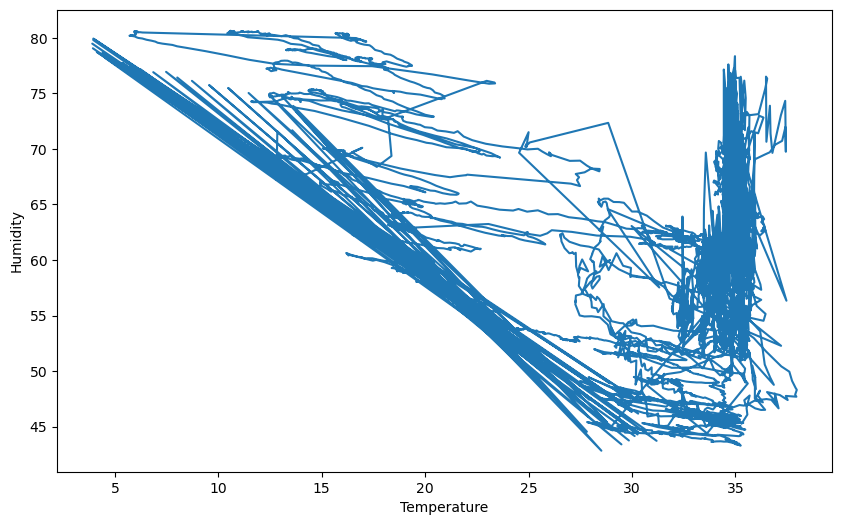

In [3]:
# Select temperature and humidity as state variables
state_variables = filtered_data[['temperature', 'humidity']]

# Plot the state space
plt.figure(figsize=(10, 6))
plt.plot(state_variables['temperature'], state_variables['humidity'])
plt.xlabel('Temperature')
plt.ylabel('Humidity')
plt.show()

4.3. Phase Portrait

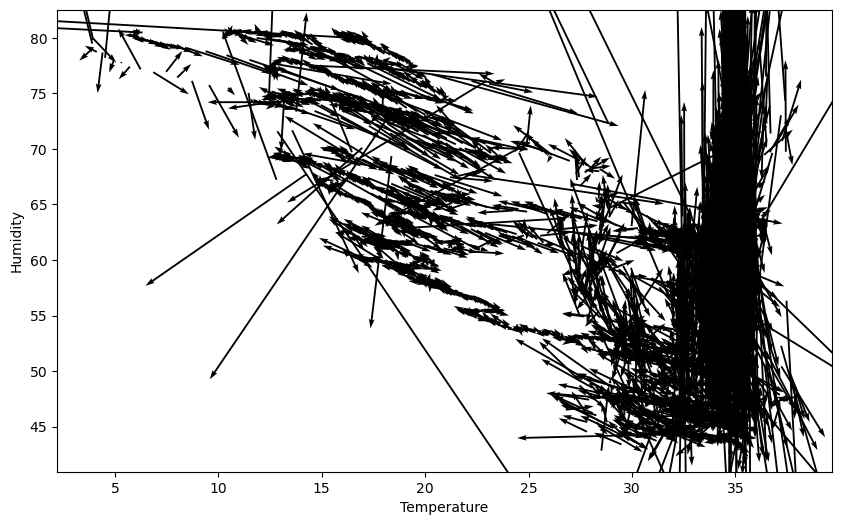

In [4]:
# Calculate velocity vectors
filtered_data['temperature_lag1'] = filtered_data['temperature'].shift(1)
filtered_data['temperature_lead1'] = filtered_data['temperature'].shift(-1)
filtered_data['temperature_vel'] = (filtered_data['temperature_lead1'] - filtered_data['temperature_lag1']) / 2

filtered_data['humidity_lag1'] = filtered_data['humidity'].shift(1)
filtered_data['humidity_lead1'] = filtered_data['humidity'].shift(-1)
filtered_data['humidity_vel'] = (filtered_data['humidity_lead1'] - filtered_data['humidity_lag1']) / 2

# Plot the phase portrait
plt.figure(figsize=(10, 6))
plt.quiver(filtered_data['temperature'], filtered_data['humidity'], filtered_data['temperature_vel'], filtered_data['humidity_vel'], scale=10)
plt.xlabel('Temperature')
plt.ylabel('Humidity')
plt.show()

4.4.Vector field

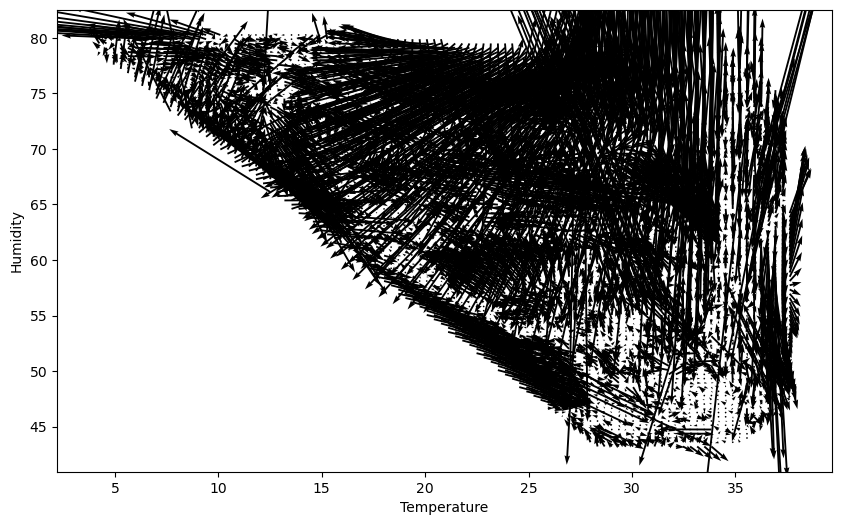

In [5]:

from scipy.interpolate import griddata

# 计算速度向量
filtered_data['temperature_lag1'] = filtered_data['temperature'].shift(1)
filtered_data['temperature_lead1'] = filtered_data['temperature'].shift(-1)
filtered_data['temperature_vel'] = (filtered_data['temperature_lead1'] - filtered_data['temperature_lag1']) / 2

filtered_data['humidity_lag1'] = filtered_data['humidity'].shift(1)
filtered_data['humidity_lead1'] = filtered_data['humidity'].shift(-1)
filtered_data['humidity_vel'] = (filtered_data['humidity_lead1'] - filtered_data['humidity_lag1']) / 2

# 去除NaN值
filtered_data = filtered_data.dropna()

# 创建网格
temp_grid = np.linspace(filtered_data['temperature'].min(), filtered_data['temperature'].max(), 100)
humidity_grid = np.linspace(filtered_data['humidity'].min(), filtered_data['humidity'].max(), 100)
temp_mesh, humidity_mesh = np.meshgrid(temp_grid, humidity_grid)

# 插值速度向量
temp_vel_grid = griddata((filtered_data['temperature'], filtered_data['humidity']), filtered_data['temperature_vel'], (temp_mesh, humidity_mesh), method='cubic')
humidity_vel_grid = griddata((filtered_data['temperature'], filtered_data['humidity']), filtered_data['humidity_vel'], (temp_mesh, humidity_mesh), method='cubic')

# 绘制向量场
plt.figure(figsize=(10, 6))
plt.quiver(temp_mesh, humidity_mesh, temp_vel_grid, humidity_vel_grid, scale=50)
plt.xlabel('Temperature')
plt.ylabel('Humidity')
plt.show()

4.5. topology

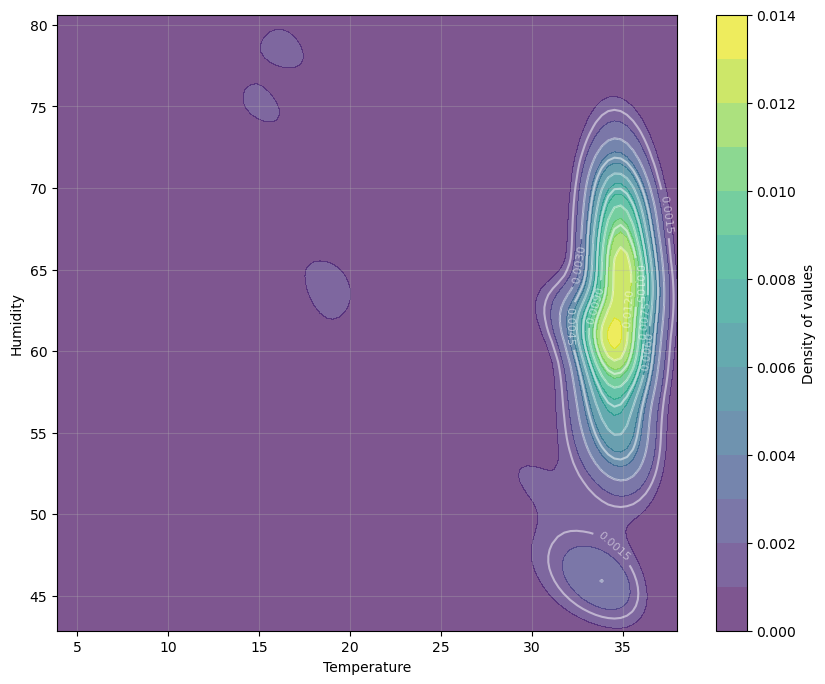

In [15]:
from scipy.stats import kde
import warnings
warnings.filterwarnings('ignore')

# Select temperature and humidity as state variables
state_variables = filtered_data[['temperature', 'humidity']]

# Calculate velocity vectors
filtered_data['temperature_lag1'] = filtered_data['temperature'].shift(1)
filtered_data['temperature_lead1'] = filtered_data['temperature'].shift(-1)
filtered_data['temperature_vel'] = (filtered_data['temperature_lead1'] - filtered_data['temperature_lag1']) / 2

filtered_data['humidity_lag1'] = filtered_data['humidity'].shift(1)
filtered_data['humidity_lead1'] = filtered_data['humidity'].shift(-1)
filtered_data['humidity_vel'] = (filtered_data['humidity_lead1'] - filtered_data['humidity_lag1']) / 2

# Create a grid of points for the vector field
temp_grid = np.linspace(filtered_data['temperature'].min(), filtered_data['temperature'].max(), 20)
humidity_grid = np.linspace(filtered_data['humidity'].min(), filtered_data['humidity'].max(), 20)
temp_mesh, humidity_mesh = np.meshgrid(temp_grid, humidity_grid)

# Interpolate velocity vectors for the grid
temp_vel_grid = np.interp(temp_mesh.ravel(), filtered_data['temperature'], filtered_data['temperature_vel']).reshape(temp_mesh.shape)
humidity_vel_grid = np.interp(humidity_mesh.ravel(), filtered_data['humidity'], filtered_data['humidity_vel']).reshape(humidity_mesh.shape)

# Calculate the density of points in the state space
k = kde.gaussian_kde([filtered_data['temperature'], filtered_data['humidity']])

# Create a grid of points for the density
temp_grid_density = np.linspace(filtered_data['temperature'].min(), filtered_data['temperature'].max(), 100)
humidity_grid_density = np.linspace(filtered_data['humidity'].min(), filtered_data['humidity'].max(), 100)
temp_mesh_density, humidity_mesh_density = np.meshgrid(temp_grid_density, humidity_grid_density)
positions = np.vstack([temp_mesh_density.ravel(), humidity_mesh_density.ravel()])
density = k(positions).reshape(temp_mesh_density.shape)

# Plot the topology with density contours and vector field
plt.figure(figsize=(10, 8))
plt.contourf(temp_mesh_density, humidity_mesh_density, density, levels=15, cmap='viridis', alpha=0.7)
plt.colorbar(label='Density of values')

# Add vector field
plt.quiver(temp_mesh, humidity_mesh, temp_vel_grid, humidity_vel_grid, color='black', scale=50)

# Add contour lines for density
contours = plt.contour(temp_mesh_density, humidity_mesh_density, density, levels=10, colors='white', alpha=0.5)
plt.clabel(contours, inline=True, fontsize=8, colors='white')

plt.xlabel('Temperature')
plt.ylabel('Humidity')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
print(clean_data.columns)

Index(['index', 'temperature', 'humidity', 'tag_number', 'geolocation',
       'hive_power', 'date', 'time', 'beehub_name', 'datetime',
       'temperature_lag1', 'temperature_lead1', 'temperature_vel',
       'humidity_lag1', 'humidity_lead1', 'humidity_vel', 'temperature_change',
       'humidity_change', 'temp_change', 'hum_change'],
      dtype='object')


In [ ]:
print(clean_data.columns)

Index(['index', 'temperature', 'humidity', 'tag_number', 'geolocation',
       'hive_power', 'date', 'time', 'beehub_name', 'datetime',
       'temperature_lag1', 'temperature_lead1', 'temperature_vel',
       'humidity_lag1', 'humidity_lead1', 'humidity_vel', 'temperature_change',
       'humidity_change', 'temp_change', 'hum_change'],
      dtype='object')


4.6. Regression Model

In [8]:
print(filtered_data.columns)

Index(['index', 'temperature', 'humidity', 'tag_number', 'geolocation',
       'hive_power', 'date', 'time', 'beehub_name', 'datetime',
       'temperature_lag1', 'temperature_lead1', 'temperature_vel',
       'humidity_lag1', 'humidity_lead1', 'humidity_vel'],
      dtype='object')


In [10]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# 1. Detailed examination of NaN values
print("Dataset size:", filtered_data.shape)

filtered_data['temperature_change'] = filtered_data['temperature_lead1'] - filtered_data['temperature']
filtered_data['humidity_change'] = filtered_data['humidity_lead1'] - filtered_data['humidity']

# Check the number of NaN values in each column
for col in ['temperature', 'humidity', 'temperature_lead1', 'humidity_lead1',
           'temperature_change', 'humidity_change']:
   na_count = filtered_data[col].isna().sum()
   na_percent = (na_count / len(filtered_data)) * 100
   print(f"{col}: {na_count} NaN values ({na_percent:.2f}%)")

# 2. Display examples of rows containing NaN values to understand the pattern
print("\nSample rows containing NaN values:")
nan_rows = filtered_data[filtered_data['temperature_change'].isna() |
                        filtered_data['humidity_change'].isna()]
print(nan_rows[['temperature', 'humidity', 'temperature_lead1', 'humidity_lead1',
               'temperature_change', 'humidity_change']].head())

# 3. Create a clean dataset with no NaN values
clean_data = filtered_data.dropna(subset=['temperature', 'humidity', 'temperature_lead1', 'humidity_lead1']).copy()
clean_data['temp_change'] = clean_data['temperature_lead1'] - clean_data['temperature']
clean_data['hum_change'] = clean_data['humidity_lead1'] - clean_data['humidity']

# Confirm no NaN values remain after cleaning
print("\nData size after cleaning and recalculation:", clean_data.shape)
for col in ['temperature', 'humidity', 'temperature_lead1', 'humidity_lead1',
           'temp_change', 'hum_change']:
   print(f"{col}: {clean_data[col].isna().sum()} NaN values")




Dataset size: (12430, 18)
temperature: 0 NaN values (0.00%)
humidity: 0 NaN values (0.00%)
temperature_lead1: 1 NaN values (0.01%)
humidity_lead1: 1 NaN values (0.01%)
temperature_change: 1 NaN values (0.01%)
humidity_change: 1 NaN values (0.01%)

Sample rows containing NaN values:
       temperature  humidity  temperature_lead1  humidity_lead1  \
16035         3.95     79.92                NaN             NaN   

       temperature_change  humidity_change  
16035                 NaN              NaN  

Data size after cleaning and recalculation: (12429, 20)
temperature: 0 NaN values
humidity: 0 NaN values
temperature_lead1: 0 NaN values
humidity_lead1: 0 NaN values
temp_change: 0 NaN values
hum_change: 0 NaN values


In [14]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR
import warnings
warnings.filterwarnings('ignore')

# Assume `clean_data` is the cleaned data containing time series data
# Prepare the dataset and ensure it's in time series format (if there is no time index, you may need to set it manually)

# 1. Data preparation
# Use 'temperature', 'humidity', 'temp_change', 'hum_change' as input variables
data = clean_data[['temperature', 'humidity', 'temp_change', 'hum_change']]

# Ensure there are no missing values
data = data.dropna()

# 2. Create the VAR model
# Set the lag order (lags), which is typically chosen based on AIC/BIC criteria or trial and error
lag_order = 5  # Here, the lag order is set to 5, but you can adjust it based on your data

# 3. Fit the VAR model
model = VAR(data)
var_results = model.fit(lag_order)

# 4. View the model summary
print(var_results.summary())

# 5. Forecasting
# Assume we want to forecast for the next 5 time steps
forecast = var_results.forecast(data.values[-lag_order:], steps=5)

# Output the forecast results
forecast_df = pd.DataFrame(forecast, columns=data.columns)
print("\nForecast for the next 5 time steps:")
print(forecast_df)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 12, May, 2025
Time:                     16:00:05
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -120.768
Nobs:                     12424.0    HQIC:                  -120.801
Log likelihood:           680090.    FPE:                3.38398e-53
AIC:                     -120.818    Det(Omega_mle):     3.36120e-53
--------------------------------------------------------------------
Results for equation temperature
                    coefficient       std. error              t-stat            prob
------------------------------------------------------------------------------------
const                  0.000000         0.000000               0.830           0.407
L1.temperature         0.618182              NAN                 NAN             NAN
L1.humidity           -0.000000       